In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import LSTM

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [33]:
df=pd.read_csv("MainData.csv")
df.shape

(11092, 248)

In [34]:
# 제거 할 변수 추가 < region1, 낙상, adl ,iadl, 악력 > 제거

df=df[df.columns.drop(list(df.filter(regex=r'(region1|adl|C056)')))]

In [35]:
df1=df.loc[:,'w01hhsize':'w01present_labor']
df2=df.loc[:,'w02hhsize':'w02present_labor']
df3=df.loc[:,'w03hhsize':'w03present_labor']
df4=df.loc[:,'w04hhsize':'w04present_labor']
df5=df.loc[:,'w05hhsize':'w05present_labor']
df6=df.loc[:,'w06hhsize':'w06present_labor']
df7=df.loc[:,'w07hhsize':'w07present_labor']
df8=df.loc[:,'w08hhsize':'w08present_labor']

In [36]:
# 1차 설문조사에 alc 과  adl점수가 없음.
print(df1.shape,df2.shape,df3.shape,df4.shape,df5.shape,df6.shape,df7.shape,df8.shape)

(11092, 26) (11092, 27) (11092, 27) (11092, 27) (11092, 27) (11092, 27) (11092, 27) (11092, 27)


In [45]:
# 여기서 11092 명 -> 4128 은 2차 ~ 8차 까지의 설문데이터가 모두 있는 경우를 의미함.
df_new=pd.concat([df2,df3,df4,df5,df6,df7,df8],axis=1).dropna(axis=0)
df_new.shape

(4128, 189)

In [46]:
X=df_new.loc[:,:'w07present_labor']
y=df_new.w08mmse

In [47]:
from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()

X=pd.DataFrame(sc.fit_transform(X))

In [48]:
X.shape

(4128, 162)

In [49]:
X=X.values.reshape(X.shape[0],6,27)
print(X.shape,y.shape) # (size,timestep,feature)

(4128, 6, 27) (4128,)


In [50]:
# Train Test Set 으로 Split 하자
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=42)

In [51]:
print(X_train.shape,X_test.shape)

(3302, 6, 27) (826, 6, 27)


# LSTM Many-to-one

In [100]:
# LSTM many-to-one 구현
K.clear_session()
model2 = Sequential() # Sequeatial Model
model2.add(LSTM(20, input_shape=(6, 27),return_sequences=False)) # (timestep, feature)
model2.add(Dense(10,activation='relu'))
model2.add(Dense(1)) # output = 1
model2.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                3840      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,061
Trainable params: 4,061
Non-trainable params: 0
_________________________________________________________________


In [101]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint("lstm.h5", save_best_only=True)
rlr = ReduceLROnPlateau(factor=0.2, patience=3)

# fit model
history = model2.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100,callbacks=[es,rlr])

Epoch 1/100


2023-01-13 13:26:22.287733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 13:26:22.399314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/83 [===>..........................] - ETA: 0s - loss: 623.5712 - root_mean_squared_error: 24.9714

2023-01-13 13:26:22.489010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 2s 12ms/step - loss: 430.7932 - root_mean_squared_error: 20.7556 - val_loss: 218.2996 - val_root_mean_squared_error: 14.7750 - lr: 0.0010
Epoch 2/100
 1/83 [..............................] - ETA: 0s - loss: 215.5128 - root_mean_squared_error: 14.6804

2023-01-13 13:26:23.385371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 13:26:23.426105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 1s 9ms/step - loss: 117.2822 - root_mean_squared_error: 10.8297 - val_loss: 52.2553 - val_root_mean_squared_error: 7.2288 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - 1s 9ms/step - loss: 35.2740 - root_mean_squared_error: 5.9392 - val_loss: 31.0790 - val_root_mean_squared_error: 5.5749 - lr: 0.0010
Epoch 4/100
83/83 [==============================] - 1s 8ms/step - loss: 28.3488 - root_mean_squared_error: 5.3244 - val_loss: 30.6286 - val_root_mean_squared_error: 5.5343 - lr: 0.0010
Epoch 5/100
83/83 [==============================] - 1s 9ms/step - loss: 28.2241 - root_mean_squared_error: 5.3126 - val_loss: 30.5828 - val_root_mean_squared_error: 5.5302 - lr: 0.0010
Epoch 6/100
83/83 [==============================] - 1s 9ms/step - loss: 26.6052 - root_mean_squared_error: 5.1580 - val_loss: 24.7714 - val_root_mean_squared_error: 4.9771 - lr: 0.0010
Epoch 7/100
83/83 [==============================] - 1s 9ms/step - loss: 21.6378

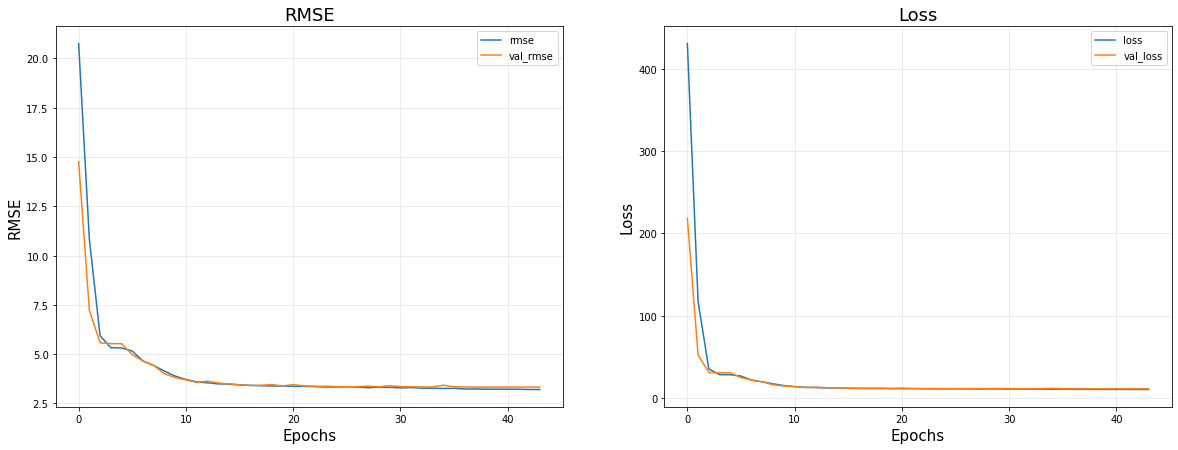

In [102]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [103]:
y_pred=model2.predict(X_test)

26/26 [==============================] - 0s 4ms/step


2023-01-13 13:26:59.767206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-13 13:26:59.801257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [104]:
import numpy as np
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_pred))

3.52621170086654

# LSTM Many to Many

In [ ]:
# LSTM many-to-many Hyperparameter Tuning
K.clear_session()
model2 = Sequential() # Sequeatial Model
model2.add(LSTM(128, input_shape=(7, 29),return_sequences=True)) # (timestep, feature)
model2.add(Dropout(0.2))
model2.add(LSTM(128,return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(16,activation='relu'))
model2.add(Dense(8,activation='relu'))
model2.add(Dense(1)) # output = 1
model2.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model2.summary()

In [173]:
# LSTM 2차 부터 8차까지 MMSE,MMSEG 를 제외한 데이터 만들기 2차~8차 MMSE 점수가 Target 변수
df=pd.read_csv("MainData.csv")

df1=df.loc[:,'w01hhsize':'w01present_labor']
df2=df.loc[:,'w02hhsize':'w02present_labor']
df3=df.loc[:,'w03hhsize':'w03present_labor']
df4=df.loc[:,'w04hhsize':'w04present_labor']
df5=df.loc[:,'w05hhsize':'w05present_labor']
df6=df.loc[:,'w06hhsize':'w06present_labor']
df7=df.loc[:,'w07hhsize':'w07present_labor']
df8=df.loc[:,'w08hhsize':'w08present_labor']

df_new=pd.concat([df2,df3,df4,df5,df6,df7,df8],axis=1).dropna(axis=0)

X=df_new.drop(['w02mmse','w02mmseg','w03mmse','w03mmseg','w04mmse','w04mmseg','w05mmse','w05mmseg','w06mmse','w06mmseg','w07mmse','w07mmseg','w08mmse','w08mmseg'],axis=1)
y=df_new[['w02mmse','w03mmse','w04mmse','w05mmse','w06mmse','w07mmse','w08mmse']]

from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()

X=pd.DataFrame(sc.fit_transform(X))

X=X.values.reshape(X.shape[0],7,29)

# Train Test Set 으로 Split 하자
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [174]:
print(X_train.shape,X_test.shape)

(3302, 7, 29) (826, 7, 29)


In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

model2.fit(X_train, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100


2022-12-07 20:54:00.808969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 20:54:01.060801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 20:54:01.135741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/111 [..............................] - ETA: 4:17 - loss: 690.8140 - root_mean_squared_error: 26.2833

2022-12-07 20:54:01.462864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 20:54:01.545891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 4s 15ms/step - loss: 117.9456 - root_mean_squared_error: 10.8603
Epoch 2/100
111/111 [==============================] - 1s 12ms/step - loss: 21.9365 - root_mean_squared_error: 4.6836
Epoch 3/100
111/111 [==============================] - 1s 12ms/step - loss: 21.7230 - root_mean_squared_error: 4.6608
Epoch 4/100
111/111 [==============================] - 1s 12ms/step - loss: 21.3791 - root_mean_squared_error: 4.6237
Epoch 5/100
111/111 [==============================] - 1s 12ms/step - loss: 21.2547 - root_mean_squared_error: 4.6103
Epoch 6/100
111/111 [==============================] - 1s 13ms/step - loss: 21.2499 - root_mean_squared_error: 4.6098
Epoch 7/100
111/111 [==============================] - 1s 13ms/step - loss: 21.1898 - root_mean_squared_error: 4.6032
Epoch 8/100
111/111 [==============================] - 1s 13ms/step - loss: 21.1647 - root_mean_squared_error: 4.6005
Epoch 9/100
111/111 [==============================] - 1s 13ms/ste

In [ ]:
y_pred=model2.predict(X_test)
y_pred=y_pred.reshape(826,7)
print(y_pred.shape)

In [188]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_pred))

3.8070109758555337

In [189]:
y_train_pred=model2.predict(X_train)
y_train_pred=y_train_pred.reshape(3302,7)
np.sqrt(mean_squared_error(y_train, y_train_pred))

104/104 [==============================] - 1s 8ms/step


2.733578384538179

(3302, 7)